# **Selenium**

**장점**
* table 형태가 아니더라도 내가 얻고 싶은 정보를 입맛대로 가져올 수 있다.
* 여러 페이지에서 정보를 가져올 수 있다.
* 로그인, 마우스 클릭, 캡쳐 등 동적으로 많은 자동화 업무를 할 수 있다.

**단점**
* 컴퓨터 사양에 따라 속도가 달라 원하는 정보를 추출하는데 시간이 걸릴 수도 있다.<br>
* 불러오는 속도와 python의 실행 속도가 맞지 않으면 오류가 난다.

## **세계 축구선수 Top200**


* **학습 목표**
    * 200위까지 선수명, 포지션, 나이, 국적, 소속, Market Value가 나타나는 데이터 프레임을 만들 수 있다.
    * 국적, 소속, 포지션 등을 통해 시각화하고, 데이터를 분석할 수 있다.

<div markdown="1" style="text-align:center; margin-bottom:10px">        
    <img src="./images/soccer_html.PNG" width="50%">
</div>


## **1) Chrome 창 열기**

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By  

chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

[WDM] - Downloading: 100%|██████████| 6.80M/6.80M [00:03<00:00, 2.19MB/s]


## **2) 사이트 이동**

In [2]:
# Chrome 열기
url = 'https://www.transfermarkt.com'
driver.get(url)

## **3) 팝업창 or iframe이 있는 경우**

In [3]:
# 페이지 전환
privacy_iframe = 'sp_message_iframe_764226'
driver.switch_to.frame(privacy_iframe)

In [4]:
# 팝업창 닫기 클릭
privacy_css = '#notice > div.message-component.message-row.mobile-reverse > div:nth-child(2) > button'
driver.find_element(By.CSS_SELECTOR, privacy_css).click()

In [5]:
# 원래 페이지로 복구
driver.switch_to.default_content()

## **4) 클릭이 되지 않을 때 : javascript 명령어로 클릭하기**

In [8]:
# onclick인 경우
players_css = '#main > header > nav > ul > li:nth-child(4) > div > div:nth-child(2) > ul > li:nth-child(2) > a'
players_url = driver.find_element(By.CSS_SELECTOR, players_css)
driver.execute_script('arguments[0].click();', players_url)

## **5) 데이터 프레임 만들기**

In [11]:
import re
import pandas as pd
import time

rank_n = 100            # 몇 위까지 수집할 것인가
cnt = 0                 # 수집된 데이터를 카운트 하기 위한 변수
page = 1                # 페이지를 넘기기 위한 변수
rows = []               # 데이터 행을 모을 변수

print('Start | ', end='')
while True:
    print(f'{page}페이지 > ', end='')
    # 페이지의 선수 목록
    players = driver.find_elements(By.CSS_SELECTOR, 'table.items > tbody > tr')

    for player in players:
        # 정보(순위, 이름, 포지션, 나이, 국적, 소속, value)접근
        rank = player.find_element(By.CSS_SELECTOR, f'td:nth-child({1})').text
        name, position = player.find_element(By.CSS_SELECTOR, f'td:nth-child({2})').text.split('\n')
        age = player.find_element(By.CSS_SELECTOR, f'td:nth-child({3})').text
        nat_sel = player.find_elements(By.CSS_SELECTOR, f'td:nth-child({4}) > img')
        nationality = ', '.join([nat.get_attribute('title') for nat in nat_sel])
        club = player.find_element(By.CSS_SELECTOR, f'td:nth-child({5}) > a').get_attribute('title')
        value_text = player.find_element(By.CSS_SELECTOR, f'td:nth-child({6}) > a').text
        value = re.sub('[^0-9.]','',value_text)

        # player 한 명이 끝날 때마다 카운트, row에 정보 추가
        cnt += 1
        rows.append([rank, name, position, nationality, club, value])

        # 지정한 rank_n까지 수집되면 멈추기(for문 나가기)
        if cnt >= rank_n:
            break
    
    # 지정한 rank_n까지 도달하지 못했다면 다음 페이지로 넘기고 아니면 멈추기(while문 나가기)
    if cnt < rank_n:
        page += 1
        page_css = f'#yw1 > div.pager > ul > li:nth-child({page}) > a'
        driver.find_element(By.CSS_SELECTOR, page_css).click()
        time.sleep(5)
    else:
        break

print('End')

columns = ['rank', 'name', 'position', 'nationality', 'club', 'value']
df = pd.DataFrame(rows, columns=columns)
df = df.set_index('rank')
df

Start | 1페이지 > 2페이지 > 3페이지 > 4페이지 > End


,name,position,nationality,club,value
rank,,,,,
1,Kylian Mbappé,Centre-Forward,"France, Cameroon",Paris Saint-Germain,180.00
2,Erling Haaland,Centre-Forward,Norway,Manchester City,170.00
3,Jude Bellingham,Central Midfield,England,Borussia Dortmund,120.00
4,Vinicius Junior,Left Winger,"Brazil, Spain",Real Madrid,120.00
5,Jamal Musiala,Attacking Midfield,"Germany, England",Bayern Munich,110.00
...,...,...,...,...,...
96,Gianluigi Donnarumma,Goalkeeper,Italy,Paris Saint-Germain,50.00
97,Lucas Hernández,Centre-Back,"France, Spain",Bayern Munich,50.00
98,Ivan Toney,Centre-Forward,"England, Jamaica",Brentford FC,50.00


# **6) 정보 추출하기**

### **most valuable player는 어떤 선수일까?**
* 상위 rank에 있는 선수들이 어떤 position을 갖고 있으며 어느 club에 소속되어 있는지 시각적으로 살펴볼 수 있다.
* position의 경우 Centre-Forward(중앙 공격수), Left Winger(왼쪽 날개) position을 가진 선수가 많았다.
* club의 경우 Manchester City, Real Madrid, Pris Saint-Germain 순으로 많았다.

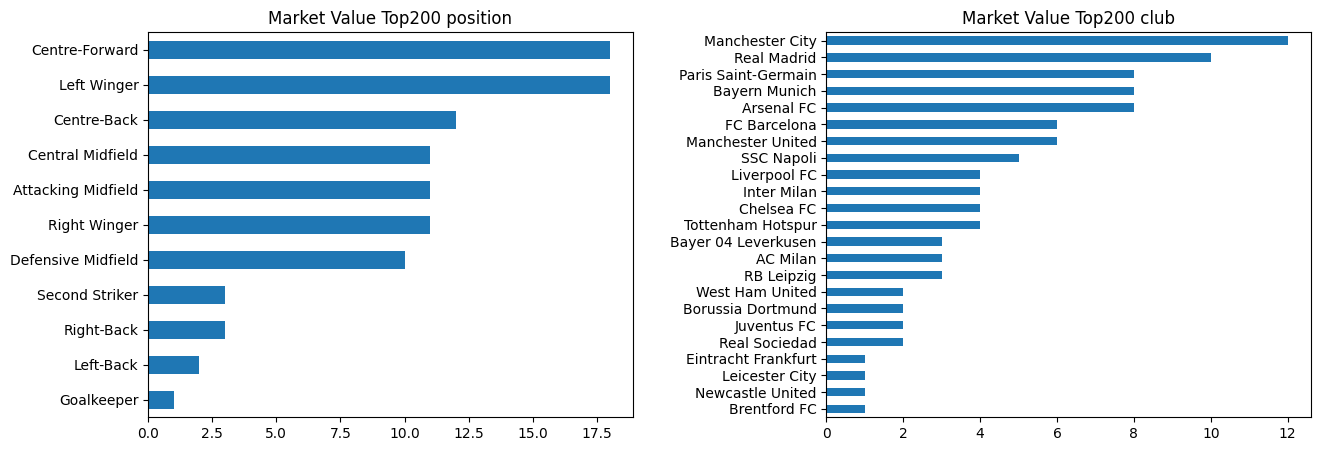

In [34]:
import matplotlib.pyplot as plt 

cols = ['position', 'club']
rank_lst = []

fig = plt.figure(figsize=(15, 5))
for i, col in enumerate(cols):
    ax = fig.add_subplot(1, 2, i+1)
    temp_df = df[col].value_counts()
    rank_lst.append(list(temp_df.index))
    temp_df.plot.barh(ax=ax)
    ax.set_title(f'Market Value Top200 {col}')
    ax.invert_yaxis()

plt.subplots_adjust(wspace=0.4)

### **각 club의 most valuable player의 소속 현황은 어떨까?**
* 선수들의 포함 여부를 통해 club의 강점/약점을 파악할 수 있다.
* Manchester City의 경우 Centre-Forward, Left Winger, Attacking Midfield에 대해 실력있는 선수가 있지만, Central Midfield는 없다. <br>
반면에 FC Barcelona는 Central Midfield인 상위 선수들이 4명이 있다.
* Paris Saint-Germain의 경우 다른 club들과 달리 Left-Back, Goalkepper position의 실력자를 갖고 있다. 

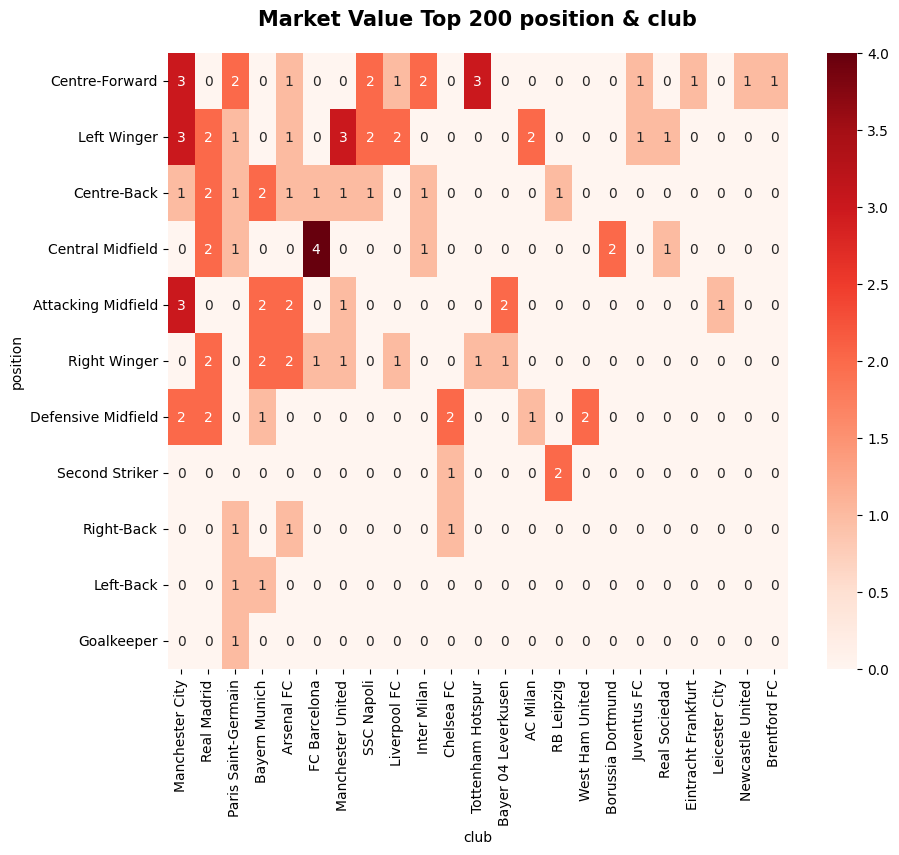

In [42]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
ct = pd.crosstab(df['position'], df['club'])
ct = ct.loc[rank_lst[0], rank_lst[1]]
sns.heatmap(ct, annot=True, cmap='Reds', ax=ax)
ax.set_title('Market Value Top 200 position & club', pad=20, size=15, fontweight='bold')

plt.show()

### **most valuable player가 가장 많은 나라는 어디일까?**

In [84]:
# 국적에 대한 dictionary 만들기
nat_dict = {}
for nat in df['nationality']:
    for n in nat.split(', '):
        if nat not in nat_dict.keys():
            nat_dict[n] = 1
        else:
            nat_dict[n] += 1

nat_dict = dict(sorted(nat_dict.items(), key=lambda x: x[1], reverse=True))
print('> Market Value Top 200 Nationality Count')
print(list(nat_dict.items())[:6])
print()

# 카운트의 분포 파악하기
from collections import Counter

count = Counter(nat_dict.values())
print('> 최고 count와 최저 count는 뭘까?')
print(count)


> Market Value Top 200 Nationality Count
[('Argentina', 6), ('Italy', 5), ('Norway', 4), ('Portugal', 4), ('Nigeria', 2), ('Georgia', 2)]

> 최고 count와 최저 count는 뭘까?
Counter({1: 29, 4: 2, 2: 2, 6: 1, 5: 1})


### **우리나라 선수 찾기**

In [95]:
nat_dict['Korea']

1

In [96]:
df.loc[df['nationality']=='Korea',:]

,name,position,nationality,club,value
rank,,,,,
